In [1]:
!pip install kaggle

In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
path = URLs.path('bluebook')
path

Path('/home/agastya/.fastai/archive/bluebook')

In [4]:
from pathlib import Path
import os

isKaggle = os.getenv('KAGGLE_KERNEL_RUN_TYPE', '')
if isKaggle:
    path = Path('../input/bluebook')
    !pip install -Uqq fastai
else:
    import zipfile, kaggle
    if not path.exists():
        kaggle.api.competition_download_cli('bluebook-for-bulldozers')
        zipfile.ZipFile('bluebook-for-bulldozers.zip').extractall(path)

In [5]:
path.ls(file_type='text')

(#7) [Path('/home/agastya/.fastai/archive/bluebook/median_benchmark.csv'),Path('/home/agastya/.fastai/archive/bluebook/ValidSolution.csv'),Path('/home/agastya/.fastai/archive/bluebook/Test.csv'),Path('/home/agastya/.fastai/archive/bluebook/random_forest_benchmark_test.csv'),Path('/home/agastya/.fastai/archive/bluebook/TrainAndValid.csv'),Path('/home/agastya/.fastai/archive/bluebook/Valid.csv'),Path('/home/agastya/.fastai/archive/bluebook/Machine_Appendix.csv')]

In [6]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,...,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,...,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,...,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,...,NaN,NaN,NaN,NaN


In [7]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

## Working out the ordinal Columns
Column with strings

In [8]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [9]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)

In [10]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [11]:
df['saledate']

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

In [12]:
# adding date metadata using date columns
df = add_datepart(df, 'saledate')

/home/agastya/mambaforge/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [13]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/home/agastya/mambaforge/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [14]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

## Using TabularPandas and TabularProc
- FastAI wrapper which helps you preprocess your data by adding `categorify` which converts ordinal data into numerical categorical column
- Also provides `FillMissing` feature which fills the missing feature with median of the feature and adds a column with boolean values for where items where missing.

In [15]:
procs = [Categorify, FillMissing]

In [16]:
# Setting validation set split condition
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
train_idx, valid_idx

(array([     0,      1,      2, ..., 412695, 412696, 412697]),
 array([ 22915,  22916,  22917, ..., 401122, 401123, 401124]))

In [17]:
splits = (list(train_idx), list(valid_idx))

In [18]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits = splits)

In [19]:
len(to.train), len(to.valid)

(404710, 7988)

In [20]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [21]:
to.items.head()

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1
3,1139251,10.558414,1026470,332,...,1,1.305763e+09,1,1
4,1139253,9.305651,1057373,17311,...,1,1.248307e+09,1,1


In [22]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [23]:
# saving the object in python's pickle system
import pickle

path = Path(path/'to.pkl')

# Open the file in write-binary mode and save the object
with path.open('wb') as file:
    pickle.dump(to, file)

In [24]:
with path.open('rb') as file:
    to = pickle.load(file)

In [25]:
## Creating The decision Tree
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [26]:
from sklearn.tree import DecisionTreeRegressor
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

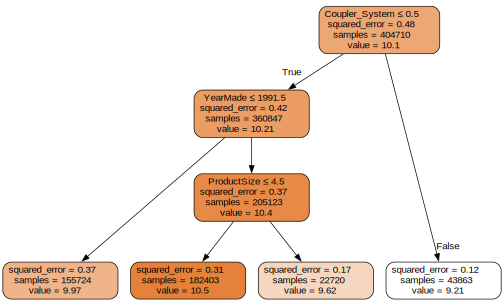

In [27]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

In [32]:
!pip install dtreeviz graphviz

In [59]:
%%skip
import dtreeviz
samp_idx = np.random.permutation(len(y))[:500]

viz_model = dtreeviz.model(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var)
print(viz_model.feature())

samp_idx = np.random.permutation(len(y))[:500]
viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')


UsageError: Line magic function `%skip` not found.


In [30]:
# Readjusting the year made
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [62]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

In [61]:
%%skip
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')
     

UsageError: Cell magic `%%skip` not found.


## Building larger Tree
- With no stopping criteria

In [65]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [66]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [67]:
m_rmse(m, xs, y)

0.0

In [69]:
# Checking Accuracy on validation set
m_rmse(m, valid_xs, valid_y)

0.335659

In [70]:
m.get_n_leaves(), len(xs)

(324564, 404710)

We've got nearly as many leaf nodes as data points! Let's add Stop condition of min_sample_leaf = 25

In [71]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248562, 0.323355)

In [73]:
m.get_n_leaves()

12397